# Optics calculation and matching for a large ring (LHC) - part 1

In [1]:
%matplotlib widget

In [2]:
import xtrack as xt

import numpy as np
import matplotlib.pyplot as plt

### Load LHC model

In [4]:
collider = xt.Multiline.from_json("hllhc15_collider_thick.json")
collider.vars.load_madx("opt_round_150_1500.madx")

collider.build_trackers()

Loading line from dict:   0%|          | 0/30281 [00:00<?, ?it/s]

Done loading line from dict.           


Loading line from dict:   0%|          | 0/30289 [00:00<?, ?it/s]

Done loading line from dict.           

This file will become unreadable in the future. We recommend to save it as an Environment object. This can be easily done as follows:

    import xtrack as xt
    env = xt.Multiline.from_json("my_old_multiline.json")
    env.to_json("my_new_environment.json")



### Initial twiss

In [5]:
tw0 = collider.lhcb1.twiss()

In [6]:
# Inspect IPS
tw0.rows['ip.*'].cols['betx bety mux muy x y']

TwissTable: 9 rows, 7 cols
name            betx          bety           mux           muy             x             y
ip1             0.15          0.15             0             0             0             0
ip2               10            10       8.23376        7.6927  -1.63469e-17    2.1467e-35
ip3          121.567       218.584       15.9494       15.4503   5.97025e-16  -3.79442e-36
ip4           236.18       306.197        23.507       22.3832  -3.23008e-16  -6.31052e-35
ip5             0.15          0.15       30.9305       29.9889    6.3932e-18  -6.71576e-37
ip6          273.434        183.74       38.7487       37.3936   3.57142e-16  -4.22326e-35
ip7          120.813       149.431       46.3524       44.5934  -1.89169e-16   7.69675e-35
ip8              1.5           1.5       54.3432       52.2729  -1.99753e-17   4.67208e-33
ip1.l1          0.15          0.15         62.31         60.32   -9.6474e-19   5.36067e-34

### Prepare for optics matching: set limits and steps for all circuits

In [7]:
import lhc_match as lm
lm.set_var_limits_and_steps(collider)

In [8]:
# Inspect for one circuit
collider.vars.vary_default['kq4.l2b2']

{'step': 1e-06, 'limits': (0.00020557714282348692, 0.0068525714274495645)}

### Twiss on a part of the machine (bidirectional)

In [9]:
tw_81_12 = collider.lhcb1.twiss(start='ip8', end='ip2', init_at='ip1',
                                betx=0.15, bety=0.15)

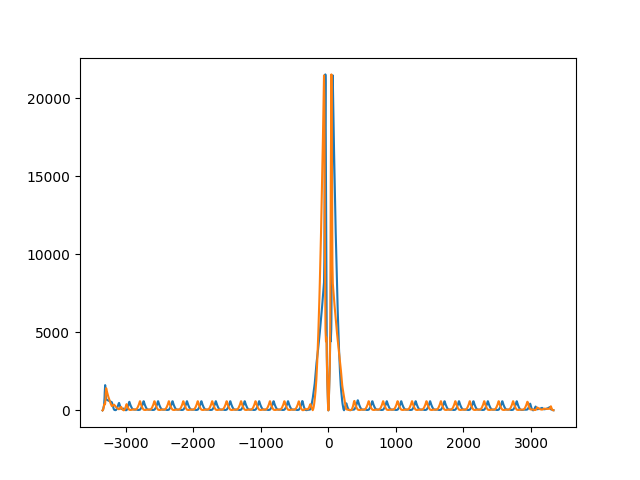

In [10]:
plt.figure()
plt.plot(tw_81_12.s, tw_81_12.betx)
plt.plot(tw_81_12.s, tw_81_12.bety)

### Telescopic rematch of IP1 using IP2 and IP8

#### Match left side

In [11]:
opt = collider.lhcb1.match(
    solve=False,
    default_tol={None: 1e-8, 'betx': 1e-6, 'bety': 1e-6, 'alfx': 1e-6, 'alfy': 1e-6},
    start='s.ds.l8.b1', end='ip1',
    init=tw0, init_at=xt.START,
    vary=[
        # Only IR8 quadrupoles including DS
        xt.VaryList(['kq6.l8b1', 'kq7.l8b1', 'kq8.l8b1', 'kq9.l8b1', 'kq10.l8b1', 
            'kqtl11.l8b1', 'kqt12.l8b1', 'kqt13.l8b1',
            'kq4.l8b1', 'kq5.l8b1', 'kq4.r8b1', 'kq5.r8b1', 
            'kq6.r8b1', 'kq7.r8b1', 'kq8.r8b1', 'kq9.r8b1', 
            'kq10.r8b1', 'kqtl11.r8b1', 'kqt12.r8b1', 'kqt13.r8b1'])],
    targets=[
        xt.TargetSet(at='ip8', tars=('betx', 'bety', 'alfx', 'alfy', 'dx', 'dpx'), value=tw0),
        xt.TargetSet(at='ip1', betx=0.15, bety=0.10, alfx=0, alfy=0, dx=0, dpx=0),
        xt.TargetRelPhaseAdvance('mux', value = tw0['mux', 'ip1.l1'] - tw0['mux', 's.ds.l8.b1']),
        xt.TargetRelPhaseAdvance('muy', value = tw0['muy', 'ip1.l1'] - tw0['muy', 's.ds.l8.b1']), 
    ])

In [14]:
opt.target_status()

Target status:               alty = 5.0000e-02              
id state tag      tol_met       residue   current_val    target_val description                                 
0  ON    ip8_betx    True  -4.31824e-10           1.5           1.5 line=lhcb1, ('betx', 'ip8'), val=1.5, to ...
1  ON    ip8_bety    True   -5.7387e-11           1.5           1.5 line=lhcb1, ('bety', 'ip8'), val=1.5, to ...
2  ON    ip8_alfx    True   1.46561e-12   2.21641e-07   2.21639e-07 line=lhcb1, ('alfx', 'ip8'), val=2.21639 ...
3  ON    ip8_alfy    True   1.83491e-12   2.15516e-07   2.15514e-07 line=lhcb1, ('alfy', 'ip8'), val=2.15514 ...
4  ON    ip8_dx      True   8.52321e-10   1.87664e-09   1.02432e-09 line=lhcb1, ('dx', 'ip8'), val=1.02432e- ...
5  ON    ip8_dpx     True    9.1681e-10   1.11905e-09   2.02244e-10 line=lhcb1, ('dpx', 'ip8'), val=2.02244e ...
6  ON    ip1_betx    True  -5.34541e-08          0.15          0.15 line=lhcb1, ('betx', 'ip1'), val=0.15, t ...
7  ON    ip1_bety   False          

In [15]:
opt.step(40)

                                             
Optimize - start penalty: 0.05                              
Matching: model call n. 446 penalty = 5.2703e-08              
Optimize - end penalty:  5.27032e-08                            


In [16]:
opt.target_status()

Target status:               enalty = 5.2703e-08              
id state tag      tol_met       residue   current_val    target_val description                                 
0  ON    ip8_betx    True   2.68359e-11           1.5           1.5 line=lhcb1, ('betx', 'ip8'), val=1.5, to ...
1  ON    ip8_bety    True   2.09528e-09           1.5           1.5 line=lhcb1, ('bety', 'ip8'), val=1.5, to ...
2  ON    ip8_alfx    True   -7.9383e-11    2.2156e-07   2.21639e-07 line=lhcb1, ('alfx', 'ip8'), val=2.21639 ...
3  ON    ip8_alfy    True     2.114e-11   2.15535e-07   2.15514e-07 line=lhcb1, ('alfy', 'ip8'), val=2.15514 ...
4  ON    ip8_dx      True  -3.42251e-10   6.82065e-10   1.02432e-09 line=lhcb1, ('dx', 'ip8'), val=1.02432e- ...
5  ON    ip8_dpx     True   2.26621e-10   4.28865e-10   2.02244e-10 line=lhcb1, ('dpx', 'ip8'), val=2.02244e ...
6  ON    ip1_betx    True   3.26894e-10          0.15          0.15 line=lhcb1, ('betx', 'ip1'), val=0.15, t ...
7  ON    ip1_bety    True  -4.365

#### Match right side

In [17]:
opt = collider.lhcb1.match(
    solve=False,
    default_tol={None: 1e-8, 'betx': 1e-6, 'bety': 1e-6, 'alfx': 1e-6, 'alfy': 1e-6},
    start='ip1', end='e.ds.r2.b1',
    init=tw0, init_at=xt.END, # <-- We match going backward in the line
    vary=[
        xt.VaryList([
            'kq9.l2b1', 'kq10.l2b1', 'kqtl11.l2b1', 'kqt12.l2b1', 'kqt13.l2b1',
            'kq9.r2b1', 'kq10.r2b1', 'kqtl11.r2b1', 'kqt12.r2b1', 'kqt13.r2b1',
            'kq4.l2b1', 'kq5.l2b1',  'kq6.l2b1', 'kq7.l2b1', 'kq8.l2b1',
            'kq6.r2b1',  'kq7.r2b1', 'kq8.r2b1', 'kq4.r2b1', 'kq5.r2b1'])],
    targets=[
        # Only IR2 quadrupoles including DS
        xt.TargetSet(at='ip1', betx=0.15, bety=0.10, alfx=0, alfy=0, dx=0, dpx=0),
        xt.TargetSet(at='ip2', tars=('betx', 'bety', 'alfx', 'alfy', 'dx', 'dpx'), value=tw0),
        xt.TargetRelPhaseAdvance('mux', value = tw0['mux', 'e.ds.r2.b1'] - tw0['mux', 'ip1']),
        xt.TargetRelPhaseAdvance('muy', value = tw0['muy', 'e.ds.r2.b1'] - tw0['muy', 'ip1']),
    ])

In [18]:
opt.step(20)

                                             
Optimize - start penalty: 0.05                              
Matching: model call n. 112 penalty = 8.9559e-09              
Optimize - end penalty:  8.9559e-09                            


In [19]:
opt.target_status()

Target status:               enalty = 8.9559e-09              
id state tag      tol_met       residue   current_val    target_val description                                 
0  ON    ip1_betx    True   8.96591e-11          0.15          0.15 line=lhcb1, ('betx', 'ip1'), val=0.15, t ...
1  ON    ip1_bety    True  -1.01818e-10           0.1           0.1 line=lhcb1, ('bety', 'ip1'), val=0.1, to ...
2  ON    ip1_alfx    True  -8.60408e-10  -8.60408e-10             0 line=lhcb1, ('alfx', 'ip1'), val=0, tol= ...
3  ON    ip1_alfy    True   6.39838e-11   6.39838e-11             0 line=lhcb1, ('alfy', 'ip1'), val=0, tol= ...
4  ON    ip1_dx      True  -1.32392e-10  -1.32392e-10             0 line=lhcb1, ('dx', 'ip1'), val=0, tol=1e ...
5  ON    ip1_dpx     True   1.10049e-12   1.10049e-12             0 line=lhcb1, ('dpx', 'ip1'), val=0, tol=1 ...
6  ON    ip2_betx    True  -1.29898e-10            10            10 line=lhcb1, ('betx', 'ip2'), val=10, tol ...
7  ON    ip2_bety    True   1.687

#### Inspect results

In [20]:
tw_new = collider.lhcb1.twiss()

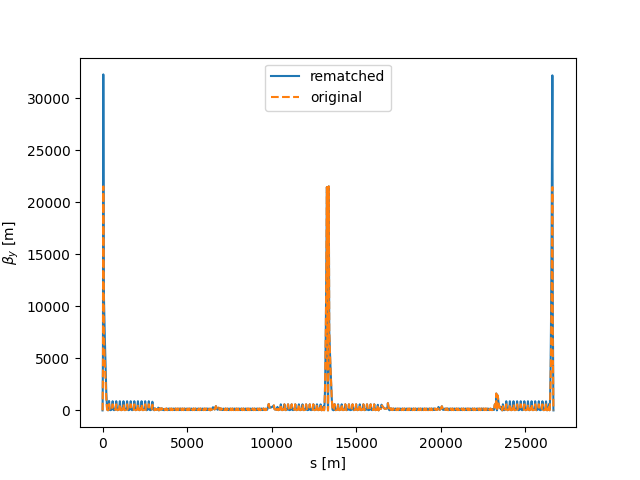

In [21]:
plt.figure()
plt.plot(tw_new.s, tw_new.bety, label='rematched')
plt.plot(tw0.s, tw0.bety, '--', label='original')
plt.xlabel('s [m]')
plt.ylabel(r'$\beta_y$ [m]')
plt.legend()

In [22]:
# Inspect table
tw_new.rows['ip.*'].cols['betx bety mux muy x y']

TwissTable: 9 rows, 7 cols
name            betx          bety           mux           muy             x             y
ip1             0.15           0.1             0             0             0             0
ip2               10            10       8.24225       7.69298  -1.40156e-17   3.87702e-35
ip3          121.567       218.584       15.9494       15.4503   4.19893e-16  -2.85687e-34
ip4           236.18       306.196        23.507       22.3832   5.93845e-17   -2.8709e-34
ip5             0.15          0.15       30.9305       29.9889   6.37071e-19    7.5437e-36
ip6          273.434       183.739       38.7487       37.3936   7.93624e-16   -2.3131e-34
ip7          120.813       149.431       46.3524       44.5934  -5.66595e-16  -1.75663e-34
ip8              1.5           1.5       54.3426       52.2588  -7.97922e-17  -1.51685e-33
ip1.l1          0.15     0.0999999         62.31         60.32  -3.50524e-17  -6.25718e-34